In [1]:
import os
import numpy as np
from pandas import read_csv
from arviz import hdi

## Section 1: 1PL-G Models

### 1.1 Model comparison

In [2]:
for i, m in enumerate(['1plg_m1','1plg_m2','1plg_m3']):
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'{m}_ppc.csv'))
        
    ## Model comparison.
    loco = -2 * ppc.groupby('subject').loco.mean().sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('%s: %0.1f | %0.1f' %(m, loco, pwaic_c))

1plg_m1: 27741.4 | 105.4
1plg_m2: 26962.1 | 164.0
1plg_m3: 26585.5 | 339.5


In [3]:
from itertools import combinations

for a, b in list(combinations(['1plg_m1','1plg_m2','1plg_m3'], 2)):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppc.csv'))
    
    arr = -2 * (df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean())
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - {a}: %0.1f (%0.1f)' %(mu, se))

1plg_m2 - 1plg_m1: -779.3 (51.4)
1plg_m3 - 1plg_m1: -1155.8 (60.1)
1plg_m3 - 1plg_m2: -376.5 (34.5)


### 1.2 Parameter distributions

In [4]:
## Load samples.
samples = read_csv(os.path.join('stan_results', '1plg_m3.tsv.gz'), sep='\t', compression='gzip')

## Extract parameters.
beta_mu   = samples.filter(regex='beta_mu\[').values
beta_1_pr = samples.filter(regex='beta_1_pr\[').values
beta      = samples.filter(regex='beta\[').values
sigma     = samples.filter(regex='sigma\[').values

## Item difficulty (mean).
mu = beta.mean()
lb, ub = hdi(beta.mean(axis=1), hdi_prob=0.95)
print('beta (mean):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (variance).
mu = beta.std(axis=1).mean()
lb, ub = hdi(beta.std(axis=1), hdi_prob=0.95)
print('beta (var):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

beta (mean):	0.177 [0.116, 0.236]
beta (var):	1.431 [1.368, 1.493]


### 1.3 Interpreting parameters

In [5]:
## Define useful functions.
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

## Load design.
X2 = read_csv(os.path.join('designs', 'X2.csv'))

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute regressor SD.
    sd = X2[col].std()
    
    ## Compute change in response.
    delta = inv_logit(beta_mu[:,0] + 0.5 * (beta_mu[:,i+1] / sd))  -\
            inv_logit(beta_mu[:,0] - 0.5 * (beta_mu[:,i+1] / sd))
    
    ## Compute summary stats.
    mu = delta.mean()
    lb, ub = hdi(delta, hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	0.132 [0.089, 0.176]
n_rul:	0.112 [0.079, 0.143]
distr:	0.252 [0.218, 0.287]
rt:	0.122 [0.093, 0.151]


### 1.4 Variance explained

In [6]:
## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv')).apply(zscore, 0).fillna(1).values
X3 = read_csv(os.path.join('designs', 'X3.csv')).values.astype(float)

## Compute variance explained by fixed effects (total).
beta_hat = X2 @ beta_mu.T
error = beta.T - beta_hat
r2 = np.var(beta_hat, axis=0).mean() / (np.var(beta_hat, axis=0).mean() + np.var(error, axis=0).mean())
print('total:\t%0.3f' %r2)

for ix, label in zip([[0,2,3,4],[0,1,3,4],[0,3,4]], ['n_feat','n_rule','lvl-1']):
    
    ## Compute predicted / error terms.
    beta_hat = X2[:,ix] @ beta_mu.T[ix]
    error = beta.T - beta_hat
    
    ## Compute variance explained.
    a = np.var(beta_hat, axis=0).mean()
    b = np.var(error, axis=0).mean()
    
    r2p = a / (a + b)
    print('%s:\t%0.3f' %(label, r2-r2p))

total:	0.641
n_feat:	0.166
n_rule:	0.209
lvl-1:	0.373


In [7]:
## Compute level-1 coefficients.
beta_0 = beta_mu[:,:3] @ X2.T[:3]
beta_1 = beta_0 + beta_1_pr @ X3.T * np.atleast_2d(sigma[:,0]).T
error = beta_1 - beta_0

## Compute variance explained.
a = np.var(beta_0, axis=1).mean()
b = np.var(error, axis=1).mean()
r2 = a / (a + b)

print('lvl-1:\t%0.3f' %r2)

lvl-1:	0.661


## Section 2: 3PL Models

### 2.1 Model comparison

In [8]:
for i, m in enumerate(['3pl_m1','3pl_m2','3pl_m3']):
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'{m}_ppc.csv'))
        
    ## Model comparison.
    loco = -2 * ppc.groupby('subject').loco.mean().sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('%s: %0.1f | %0.2f' %(m, loco, pwaic_c))

3pl_m1: 26419.6 | 385.47
3pl_m2: 26414.5 | 408.13
3pl_m3: 26417.8 | 428.17


In [9]:
from itertools import combinations

for b in ['1plg_m1','1plg_m2','1plg_m3','3pl_m1','3pl_m3']:
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'3pl_m2_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppc.csv'))
    
    arr = -2 * (df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean())
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - 3pl_m2: %0.2f (%0.2f)' %(mu, se))

1plg_m1 - 3pl_m2: 1326.87 (62.88)
1plg_m2 - 3pl_m2: 547.56 (37.79)
1plg_m3 - 3pl_m2: 171.05 (12.65)
3pl_m1 - 3pl_m2: 5.12 (4.07)
3pl_m3 - 3pl_m2: 3.29 (1.84)


### 2.2 Parameter distributions

In [10]:
## Load samples.
samples = read_csv(os.path.join('stan_results', '3pl_m2.tsv.gz'), sep='\t', compression='gzip')

## Extract parameters.
beta_mu   = samples.filter(regex='beta_mu\[').values
beta_1_pr = samples.filter(regex='beta_1_pr\[').values
beta      = samples.filter(regex='beta\[').values
alpha_mu  = samples.filter(regex='alpha_mu\[').values
alpha     = samples.filter(regex='alpha\[').values
sigma     = samples.filter(regex='sigma\[').values
c = -0.625

## Item difficulty (mean).
mu = beta.mean()
lb, ub = hdi(beta.mean(axis=1), hdi_prob=0.95)
print('beta (mean):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (variance).
mu = beta.std(axis=1).mean()
lb, ub = hdi(beta.std(axis=1), hdi_prob=0.95)
print('beta (var):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (min).
arr = beta[:,np.argmin(beta.mean(axis=0))]
mu = arr.mean()
lb, ub = hdi(arr, hdi_prob=0.95)
print('beta (min):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (max).
arr = beta[:,np.argmax(beta.mean(axis=0))]
mu = arr.mean()
lb, ub = hdi(arr, hdi_prob=0.95)
print('beta (max):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item discrimination (mean).
mu = alpha.mean()
lb, ub = hdi(alpha.mean(axis=1), hdi_prob=0.95)
print('alpha (mean):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Item difficulty (variance).
mu = alpha.std(axis=1).mean()
lb, ub = hdi(alpha.std(axis=1), hdi_prob=0.95)
print('alpha (var):\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

## Compute correlation.
rho = np.array([np.corrcoef(a,b)[0,1] for a, b in zip(alpha, beta)])
mu = rho.mean()
lb, ub = hdi(rho, hdi_prob=0.95)
print('rho:\t\t%0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

beta (mean):	0.221 [0.142, 0.302]
beta (var):	1.554 [1.475, 1.629]
beta (min):	-3.704 [-4.687, -2.775]
beta (max):	3.497 [2.481, 4.635]
alpha (mean):	1.298 [1.212, 1.385]
alpha (var):	0.221 [0.121, 0.322]
rho:		-0.060 [-0.379, 0.250]


### 2.3 Interpreting parameters

#### Item difficulty

In [11]:
## Define useful functions.
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

## Load design.
X2 = read_csv(os.path.join('designs', 'X2.csv'))

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute regressor SD.
    sd = X2[col].std()
    
    ## Compute change in response.
    arr = beta_mu[:,i+1] / sd
    
    ## Compute summary stats.
    mu = arr.mean()
    lb, ub = hdi(arr, hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	0.579 [0.389, 0.770]
n_rul:	0.514 [0.378, 0.663]
distr:	1.105 [0.940, 1.269]
rt:	0.541 [0.414, 0.671]


In [12]:
## Define useful functions.
def inv_logit(x):
    return 1. / (1 + np.exp(-x))

## Load design.
X2 = read_csv(os.path.join('designs', 'X2.csv'))

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute regressor SD.
    sd = X2[col].std()
    
    ## Compute change in response.
    delta = (0.25 + (1-0.25) * inv_logit(beta_mu[:,0] + 0.5 * (beta_mu[:,i+1] / sd)))  -\
            (0.25 + (1-0.25) * inv_logit(beta_mu[:,0] - 0.5 * (beta_mu[:,i+1] / sd)))
    
    ## Compute summary stats.
    mu = delta.mean()
    lb, ub = hdi(delta, hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	0.106 [0.072, 0.141]
n_rul:	0.095 [0.070, 0.122]
distr:	0.199 [0.172, 0.228]
rt:	0.099 [0.075, 0.122]


#### Item discrimination

In [13]:
from scipy.stats import norm

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute summary stats.
    mu = alpha_mu[:,i+1].mean()
    lb, ub = hdi(alpha_mu[:,i+1], hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	-0.037 [-0.090, 0.017]
n_rul:	0.067 [0.011, 0.123]
distr:	-0.036 [-0.082, 0.006]
rt:	-0.025 [-0.075, 0.024]


In [14]:
from scipy.stats import norm

## Load design.
X2 = read_csv(os.path.join('designs', 'X2.csv'))

## Iterate over fixed effects.
for i, col in enumerate(['n_features', 'n_rules', 'distractor', 'rt']):
    
    ## Compute regressor SD.
    sd = X2[col].std()
    
    ## Compute change in discrimination.
    delta = norm.cdf(alpha_mu[:,0] + 0.5 * (alpha_mu[:,i+1] / sd))  -\
            norm.cdf(alpha_mu[:,0] - 0.5 * (alpha_mu[:,i+1] / sd))
    
    ## Compute summary stats.
    mu = delta.mean()
    lb, ub = hdi(delta, hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

n_fea:	-0.015 [-0.036, 0.008]
n_rul:	0.020 [0.003, 0.037]
distr:	-0.029 [-0.065, 0.005]
rt:	-0.010 [-0.030, 0.009]


### 2.4 Variance explained

#### Item difficulty

In [15]:
## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv')).apply(zscore, 0).fillna(1).values
X3 = read_csv(os.path.join('designs', 'X3.csv')).values.astype(float)

## Compute variance explained by fixed effects (total).
beta_hat = X2 @ beta_mu.T
error = beta.T - beta_hat
r2 = np.var(beta_hat, axis=0).mean() / (np.var(beta_hat, axis=0).mean() + np.var(error, axis=0).mean())
print('total:\t%0.3f' %r2)

for ix, label in zip([[0,2,3,4],[0,1,3,4],[0,3,4],[0,4]], ['n_feat','n_rule','lvl-1','big 3']):
    
    ## Compute predicted / error terms.
    beta_hat = X2[:,ix] @ beta_mu.T[ix]
    error = beta.T - beta_hat
    
    ## Compute variance explained.
    a = np.var(beta_hat, axis=0).mean()
    b = np.var(error, axis=0).mean()
    
    r2p = a / (a + b)
    print('%s:\t%0.3f' %(label, r2-r2p))

total:	0.649
n_feat:	0.163
n_rule:	0.225
lvl-1:	0.386
big 3:	0.520


In [16]:
## Compute level-1 coefficients.
beta_0 = beta_mu[:,:3] @ X2.T[:3]
beta_1 = beta_0 + beta_1_pr @ X3.T * np.atleast_2d(sigma[:,0]).T
error = beta_1 - beta_0

## Compute variance explained.
a = np.var(beta_0, axis=1).mean()
b = np.var(error, axis=1).mean()
r2 = a / (a + b)
print('lvl-1:\t%0.3f' %r2)

for ix, label in zip([[0,2],[0,1]], ['n_feat','n_rule']):
    
    ## Compute predicted / error terms.
    beta_hat = X2[:,ix] @ beta_mu.T[ix]
    error = beta_1.T - beta_hat
    
    ## Compute variance explained.
    a = np.var(beta_hat, axis=0).mean()
    b = np.var(error, axis=0).mean()
    
    r2p = a / (a + b)
    print('%s:\t%0.3f' %(label, r2-r2p))

lvl-1:	0.676
n_feat:	0.295
n_rule:	0.406


#### Item Discrimination

In [17]:
from scipy.stats import norm

## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv(os.path.join('designs', 'X2.csv')).apply(zscore, 0).fillna(1).values

## Compute predicted / error terms.
mu = norm.cdf(c + X2 @ alpha_mu.T) * 5
error = alpha.T - mu

## Compute variance explained.
a = np.var(mu, axis=0).mean()
b = np.var(error, axis=0).mean()
r2 = a / (a + b)
print('total:\t%0.3f' %r2)

for ix, label in zip([[0,3,4]], ['lvl-1']):
    
    ## Compute predicted / error terms.
    mu = norm.cdf(c + X2[:,ix] @ alpha_mu.T[ix]) * 5
    error = alpha.T - mu
    
    ## Compute variance explained.
    a = np.var(mu, axis=0).mean()
    b = np.var(error, axis=0).mean()
    
    r2p = a / (a + b)
    print('%s:\t%0.3f' %(label, r2-r2p))

total:	0.474
lvl-1:	0.319


### 2.5 Residual clone variance 

#### Estimated varability

In [18]:
mu = np.median(sigma[:,1])
lb, ub = hdi(sigma[:,1], hdi_prob=0.95)

print('sigma[2]: %0.3f [%0.3f, %0.3f]' %(mu, lb, ub))

sigma[2]: 0.620 [0.538, 0.701]


#### Empirical differences

In [19]:
## Extract clone-level random effects. 
beta_2 = sigma[:,1,np.newaxis] * samples.filter(regex='beta_2_pr\[').values

## Organize item & distractor type.
beta_2 = beta_2.reshape(len(beta_2), 128, 3)

## Compute mean absolute difference.
D = np.array([[1,-1,0], [1,0,-1], [0,1,-1]])
MAD = np.abs(beta_2 @ D).mean(axis=-1)

## Compute summary statistics (across sets).
arr = MAD.mean(axis=-1)
mu = arr.mean()
lb, ub = hdi(arr, hdi_prob=0.95)

print('MAD:\t%0.3f [%0.3f, %0.3f]' %(mu,lb,ub))

MAD:	0.705 [0.612, 0.786]


## Section 3: Explanatory IRT

In [20]:
## Extract parameters.
theta = samples.filter(regex='theta\[').values
rho   = samples.filter(regex='rho\[').values

### 3.1 Interpreting parameters

In [21]:
## Load and prepare design matrices.
X1 = read_csv(os.path.join('designs', 'X1.csv'))

for i, col in enumerate(X1.columns):
    
    ## Compute summary stats.
    mu = rho[:,i].mean()
    lb, ub = hdi(rho[:,i], hdi_prob=0.95)
    
    ## Print.
    print('%s:\t%0.3f [%0.3f, %0.3f]' %(col[:5],mu,lb,ub))

age:	-0.299 [-0.353, -0.246]
gende:	0.128 [0.078, 0.182]
rt_0:	0.427 [0.374, 0.478]
rt_1:	0.368 [0.313, 0.424]


#### 3.2 Variance explained

In [22]:
## Load and prepare design matrices.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X1 = read_csv(os.path.join('designs', 'X1.csv')).apply(zscore, 0).fillna(1).values

## Compute predicted / error terms.
theta_mu = X1 @ rho.T
error = theta.T - theta_mu

## Compute variance explained.
a = np.var(theta_mu, axis=0).mean()
b = np.var(error, axis=0).mean()
r2 = a / (a + b)
print('total:\t%0.3f' %r2)

total:	0.503


## Section 4: Model Diagnostics

### 4.1 Chi-square measure

x2 = 15.904 (pppv = 0.297)


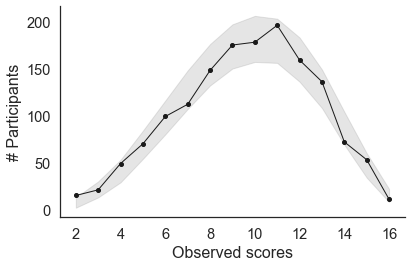

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

## Load posterior predictive check.
df = read_csv(os.path.join('stan_results', f'3pl_m2_x2.csv'), index_col=0)

## Extract values (dropping the two noisiest bins).
NC  = df.values[0,2:]
NCr = df.values[1:,2:]
ENC = NCr.mean(axis=0)

## Compute 95% HDI.
lb, ub = np.apply_along_axis(hdi, 0, NCr, hdi_prob=0.95)

## Compute chi-square statistics.
xi = np.sum(np.divide(np.square(NC - ENC), ENC, where=ENC > 0))
xr = np.divide(np.square(NCr - ENC), ENC, where=ENC > 0).sum(axis=1)

## Compute ppp-value.
pppv = (xi <= xr).mean()
print('x2 = %0.3f (pppv = %0.3f)' %(xi, pppv))

## Initialize canvas.
fig, ax = plt.subplots(1, 1, figsize=(6,4))

## Plot observed scores and 95% HDI.
ax.plot(np.arange(2,17), NC, 'o-', color='k', lw=1, markersize=4)    
ax.fill_between(np.arange(2,17), lb, ub, color='0.5', alpha=0.2)

## Add detail.
ax.set(xticks=np.arange(2,17,2),  xlabel='Observed scores', ylabel='# Participants')

sns.despine()
plt.tight_layout()

### SGDDM

In [24]:
## Load posterior predictive check.
df = read_csv(os.path.join('stan_results', f'3pl_m2_sgddm.csv'), index_col=0)
df.head(1)

,k2,obs,pred,pval
k1,,,,
0,0,0.017972,0.017534,0.0194


## Section 5: Plotting

### 5.1 Figure 02

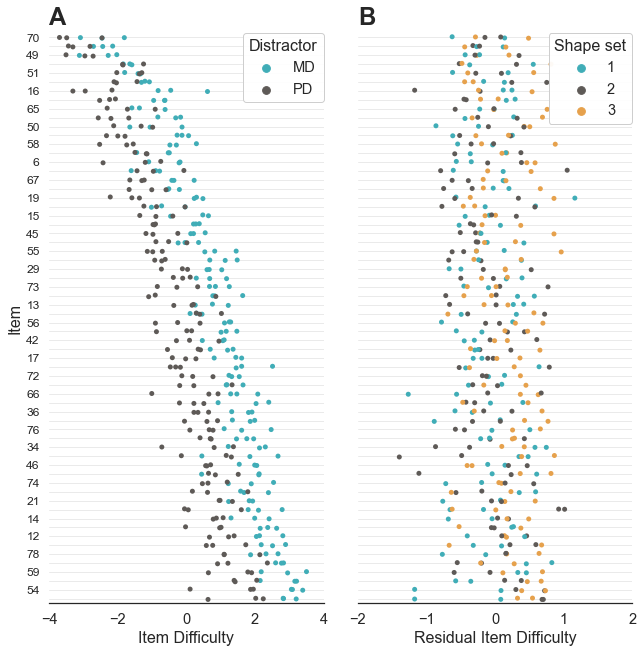

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load item features.
design = read_csv(os.path.join('designs', 'features.csv'), usecols=np.arange(6))

## Load and prepare item difficulty.
summary = read_csv(os.path.join('stan_results', '3pl_m2_summary.tsv'), sep='\t', index_col=0)  
design['beta'] = summary.T.filter(regex='beta\[').T['Mean'].values
design['beta_2'] = summary.T.filter(regex='beta_2_pr').T['Mean'].values *\
                   summary.T.filter(regex='sigma\[2').T['Mean'].values

## Format data.
design = design.replace({'md':'MD', 'pd':'PD'})

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1, 2, figsize=(9,9), sharey=True)

## Define plotting variables.
order = design.groupby('item').beta.mean().sort_values().index
palette = ['#40adb7', '#5E5A57', '#e6a14c']
hues = ['distractor', 'shape_set']
xvars = ['beta','beta_2']
xlims = [(-4,4), (-2,2)]

## Iteratively plot.
for ax, x, xlim, hue, label in zip(axes, xvars, xlims, hues, ['A','B']):

    ## Plot item difficulty parameters.
    sns.stripplot(x=x, y='item', hue=hue, data=design, order=order, palette=palette,
                  orient='h', ax=ax)
    
    ## Add grid.
    ax.grid(axis='y', alpha=0.4)
    
    ## Add details.
    ax.set_yticklabels([str(l) if not i % 2 else '' for i, l in enumerate(order)], fontsize=12)
    ax.set(xlim=xlim, xlabel='Item Difficulty', ylabel='')
    if label == 'A': ax.set_ylabel('Item', fontsize=16)
    if label == 'B': ax.set_xlabel('Residual Item Difficulty')
    
    ## Add legend.
    ax.legend(loc=1, borderaxespad=0, title=hue.replace('_',' ').capitalize(), framealpha=0.95)
    
    ## Add label.
    ax.annotate(label, (0,0), (0,1.005), 'axes fraction', ha='left', va='bottom', 
                fontsize=24, fontweight='bold')

## Adjust figure spacing.
sns.despine(left=True, right=True, top=True)
plt.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.07, wspace=0.125)

## Save figure.
plt.savefig(os.path.join('..', '05_Figures', 'fig02.png'), dpi=100)

## Section 6: Supplementary materials

### 6.1 1PL models

In [26]:
for i, m in enumerate(['1pl_m1','1pl_m2','1pl_m3']):
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'{m}_ppc.csv'))
        
    ## Model comparison.
    loco = -2 * ppc.groupby('subject').loco.mean().sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('%s: %0.1f | %0.1f' %(m, loco, pwaic_c))

1pl_m1: 28376.7 | 118.9
1pl_m2: 27627.6 | 153.4
1pl_m3: 27218.7 | 264.0


In [27]:
from itertools import combinations

for m in [1,2,3]:
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'1plg_m{m}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'1pl_m{m}_ppc.csv'))
    
    arr = -2 * (df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean())
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'1plg_m{m} - 1pl_m{m}: %0.1f (%0.1f)' %(mu, se))

1plg_m1 - 1pl_m1: 635.3 (29.7)
1plg_m2 - 1pl_m2: 665.6 (32.2)
1plg_m3 - 1pl_m3: 633.1 (33.9)


### 6.2 Removing RTs as explanatory variable

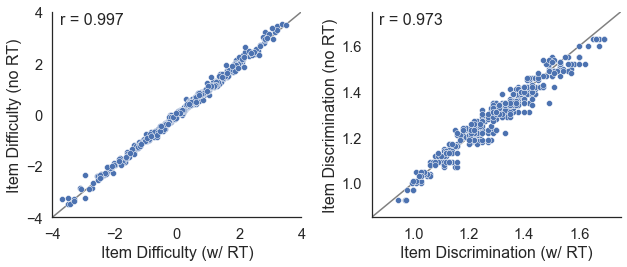

In [28]:
## Initialize canvas.
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

## Load Stan summaries.
df1 = read_csv(os.path.join('stan_results','3pl_m2_summary.tsv'), sep='\t', index_col=0)
df2 = read_csv(os.path.join('stan_results','3pl_m2b_summary.tsv'), sep='\t', index_col=0)

## Compare item difficulty.
beta_1 = df1.T.filter(regex='beta\[').T['Mean'].values
beta_2 = df2.T.filter(regex='beta\[').T['Mean'].values
corr = np.corrcoef(beta_1, beta_2)[0,1]

## Plot item difficulty.
sns.scatterplot(x=beta_1, y=beta_2, ax=axes[0])
axes[0].plot([-4,4], [-4,4], color='0.5', zorder=-1)

## Add detail.
axes[0].annotate('r = %0.3f' %corr, (0,0), (0.03,1), xycoords='axes fraction', va='top', ha='left')
axes[0].set(xlim=(-4,4), xlabel='Item Difficulty (w/ RT)', 
            ylim=(-4,4), ylabel='Item Difficulty (no RT)')

## Compare item discrimination.
alpha_1 = df1.T.filter(regex='alpha\[').T['Mean'].values
alpha_2 = df2.T.filter(regex='alpha\[').T['Mean'].values
corr = np.corrcoef(alpha_1, alpha_2)[0,1]

## Plot item difficulty.
sns.scatterplot(x=alpha_1, y=alpha_2, ax=axes[1])
axes[1].plot((0.85,1.75), (0.85,1.75), color='0.5', zorder=-1)

## Add detail.
axes[1].annotate('r = %0.3f' %corr, (0,0), (0.03,1), xycoords='axes fraction', va='top', ha='left')
axes[1].set(xlim=(0.85,1.75), xlabel='Item Discrimination (w/ RT)', 
            ylim=(0.85,1.75), ylabel='Item Discrimination (no RT)')

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join('..','05_Figures','figS03.png'))